# Data Discovery

# Libraries & Paths

In [1]:
from Bio import SeqIO
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np
import h5py
from tqdm import tqdm


In [2]:
# Path to your FASTA file
fasta_path = "/home/onur/Desktop/Project/data/cleaned_mobidb_silver_clustered_40"

output_embedding_path = "/home/onur/Desktop/Project/last-embed/output_layer_embeddings.h5"
layer16_embedding_path = "/home/onur/Desktop/Project/last-embed/layer16_embeddings.h5"
log_path = "/home/onur/Desktop/Project/last-embed/processed_sequences.log"


## Fasta File

In [30]:

# Parse FASTA
sequences = list(SeqIO.parse(fasta_path, "fasta"))
print(f" Total sequences parsed: {len(sequences)}")

 Total sequences parsed: 280589


In [31]:
# Sequence lengths
seq_lengths = [len(record.seq) for record in sequences]

print(f" Min length: {min(seq_lengths)}")
print(f" Max length: {max(seq_lengths)}")
print(f" Avg length: {np.mean(seq_lengths):.2f}")
print(f" Median length: {np.median(seq_lengths)}")


 Min length: 13
 Max length: 2000
 Avg length: 405.81
 Median length: 308.0


In [39]:
length_freq = Counter(seq_lengths)
top_lengths = length_freq.most_common(10)
print("Top 10 most common sequence lengths:")
for length, freq in top_lengths:
    print(f"Length: {length}, Count: {freq}")

Top 10 most common sequence lengths:
Length: 102, Count: 762
Length: 108, Count: 761
Length: 109, Count: 761
Length: 104, Count: 754
Length: 106, Count: 752
Length: 107, Count: 751
Length: 105, Count: 750
Length: 113, Count: 743
Length: 99, Count: 734
Length: 111, Count: 727


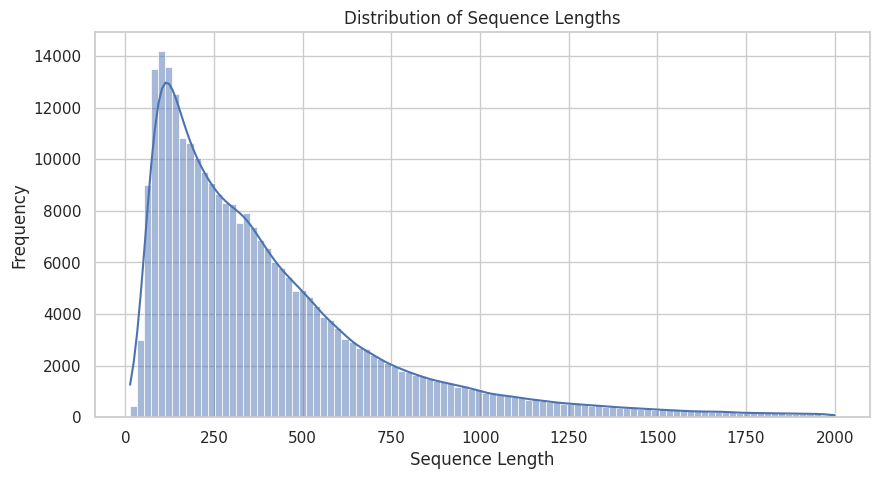

In [32]:
# Plot distribution of sequence lengths
plt.figure(figsize=(10, 5))
sns.histplot(seq_lengths, bins=100, kde=True)
plt.title("Distribution of Sequence Lengths")
plt.xlabel("Sequence Length")
plt.ylabel("Frequency")
plt.show()


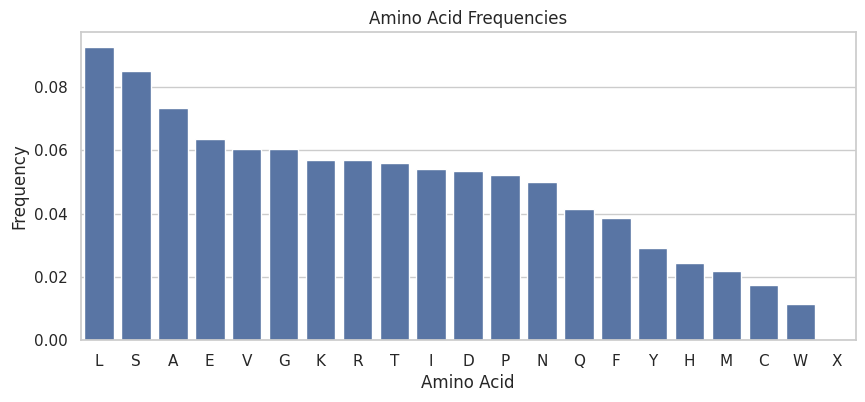

In [33]:
# Concatenate all sequences
all_aas = "".join(str(record.seq) for record in sequences)

# Count amino acids
aa_counts = Counter(all_aas)
aa_freq = {k: v / len(all_aas) for k, v in aa_counts.items()}
sorted_freq = dict(sorted(aa_freq.items(), key=lambda item: item[1], reverse=True))

# Plot frequencies
plt.figure(figsize=(10, 4))
sns.barplot(x=list(sorted_freq.keys()), y=list(sorted_freq.values()))
plt.title("Amino Acid Frequencies")
plt.xlabel("Amino Acid")
plt.ylabel("Frequency")
plt.show()


In [34]:
standard_aa = set("ACDEFGHIKLMNPQRSTVWY")
nonstandard = {aa for aa in aa_counts if aa not in standard_aa}

if nonstandard:
    print(f" Found non-standard amino acids: {nonstandard}")
else:
    print(" All amino acids are standard.")


 Found non-standard amino acids: {'X'}


In [35]:
ids = [record.id for record in sequences]
unique_ids = set(ids)
print(f" Number of Unique IDs: {len(unique_ids)} / {len(ids)}")

if len(unique_ids) < len(ids):
    print(" Duplicate sequence IDs found!")


 Number of Unique IDs: 280589 / 280589


In [36]:
# Very long sequences
long_seqs = [r for r in sequences if len(r.seq) > 2000]
print(f" Sequences longer than 2000 residues: {len(long_seqs)}")

# Very short sequences
short_seqs = [r for r in sequences if len(r.seq) < 50]
print(f" Sequences shorter than 50 residues: {len(short_seqs)}")


 Sequences longer than 2000 residues: 0
 Sequences shorter than 50 residues: 2759


## Embeddings

In [3]:
# Load HDF5 keys
with h5py.File(output_embedding_path, "r") as f:
    output_keys = set(f.keys())
with h5py.File(layer16_embedding_path, "r") as f:
    layer16_keys = set(f.keys())

# Load log file
with open(log_path, "r") as f:
    log_ids = [line.strip() for line in f if line.strip()]
log_set = set(log_ids)

In [4]:
# Count checks
print(f" Output Layer Embeddings: {len(output_keys)}")
print(f" Layer 16 Embeddings    : {len(layer16_keys)}")
print(f" Log File Entries       : {len(log_ids)}")
print(f" Unique Log IDs         : {len(log_set)}")

 Output Layer Embeddings: 280589
 Layer 16 Embeddings    : 280589
 Log File Entries       : 280589
 Unique Log IDs         : 280589


In [5]:
# Duplicate check
log_counts = Counter(log_ids)
dupes = [item for item, count in log_counts.items() if count > 1]

if dupes:
    print(f" Duplicates found in log file (e.g., {dupes[:5]})")
else:
    print(" No duplicates in log file.")

# Cross-checks
print(f" Output-layer overlap with log: {len(output_keys & log_set)}")
print(f" Layer-16 overlap with log   : {len(layer16_keys & log_set)}")

 No duplicates in log file.
 Output-layer overlap with log: 280589
 Layer-16 overlap with log   : 280589


In [6]:

with h5py.File(output_embedding_path, "r") as f:
    print(" File opened successfully.")
    
    # Print total number of protein entries
    print(f" Total protein entries: {len(f)}")

    # Peek at the first few keys (protein IDs)
    example_keys = list(f.keys())[5:10]
    print("\n Sample protein IDs:", example_keys)
    print("******** Output Layer Embeddings ********")
    for key in example_keys:
        data = f[key]
        
        print(f"\n Protein ID: {key}")
        print(f" - Data type     : {data.dtype}")
        print(f" - Shape         : {data.shape}")  # Should be (L, 1024), where L = sequence length
        print(f" - Compression   : {data.compression}")
        print(f" - Size in bytes : {data.size * data.dtype.itemsize:,} bytes")

 File opened successfully.
 Total protein entries: 280589

 Sample protein IDs: ['A0A016S1E2', 'A0A016UNP9', 'A0A016W906', 'A0A017HQV5', 'A0A017T5A5']
******** Output Layer Embeddings ********

 Protein ID: A0A016S1E2
 - Data type     : float16
 - Shape         : (129, 1024)
 - Compression   : lzf
 - Size in bytes : 264,192 bytes

 Protein ID: A0A016UNP9
 - Data type     : float16
 - Shape         : (81, 1024)
 - Compression   : lzf
 - Size in bytes : 165,888 bytes

 Protein ID: A0A016W906
 - Data type     : float16
 - Shape         : (295, 1024)
 - Compression   : lzf
 - Size in bytes : 604,160 bytes

 Protein ID: A0A017HQV5
 - Data type     : float16
 - Shape         : (120, 1024)
 - Compression   : lzf
 - Size in bytes : 245,760 bytes

 Protein ID: A0A017T5A5
 - Data type     : float16
 - Shape         : (398, 1024)
 - Compression   : lzf
 - Size in bytes : 815,104 bytes


In [7]:
sample_id = "A0A016UNP9"  # Replace with another ID if needed

with h5py.File(output_embedding_path, "r") as f:
    if sample_id in f:
        emb = f[sample_id][:]
        print(f" Embedding shape: {emb.shape}")
        print(f" First 5 residues of embedding:\n{emb[:5]}")  # 5 rows
    else:
        print("❌ Sample ID not found in the file.")

 Embedding shape: (81, 1024)
 First 5 residues of embedding:
[[ 0.03098   0.06097  -0.05588  ...  0.3582    0.2252    0.0831  ]
 [-0.1582   -0.11017  -0.03198  ...  0.2491    0.2937    0.12067 ]
 [ 0.0598   -0.1134    0.01984  ...  0.2986    0.1691   -0.2384  ]
 [-0.212     0.002192 -0.3237   ...  0.13      0.1602    0.04282 ]
 [-0.233    -0.03708  -0.06866  ...  0.1592    0.08356  -0.2451  ]]


In [8]:

with h5py.File(layer16_embedding_path, "r") as f:
    print("✅ File opened successfully.")
    
    # Print total number of protein entries
    print(f" Total protein entries: {len(f)}")

    # Peek at the first few keys (protein IDs)
    example_keys = list(f.keys())[500:505]
    print("\n Sample protein IDs:", example_keys)
    print("******** Layer 16 Embeddings ********")
    for key in example_keys:
        data = f[key]
        
        print(f"\n Protein ID: {key}")
        print(f" - Data type     : {data.dtype}")
        print(f" - Shape         : {data.shape}")  # Should be (L, 1024), where L = sequence length
        print(f" - Compression   : {data.compression}")
        print(f" - Size in bytes : {data.size * data.dtype.itemsize:,} bytes")

✅ File opened successfully.
 Total protein entries: 280589

 Sample protein IDs: ['A0A044QZD1', 'A0A044QZF6', 'A0A044QZG1', 'A0A044QZI8', 'A0A044QZJ9']
******** Layer 16 Embeddings ********

 Protein ID: A0A044QZD1
 - Data type     : float32
 - Shape         : (352, 1024)
 - Compression   : lzf
 - Size in bytes : 1,441,792 bytes

 Protein ID: A0A044QZF6
 - Data type     : float32
 - Shape         : (477, 1024)
 - Compression   : lzf
 - Size in bytes : 1,953,792 bytes

 Protein ID: A0A044QZG1
 - Data type     : float32
 - Shape         : (218, 1024)
 - Compression   : lzf
 - Size in bytes : 892,928 bytes

 Protein ID: A0A044QZI8
 - Data type     : float32
 - Shape         : (854, 1024)
 - Compression   : lzf
 - Size in bytes : 3,497,984 bytes

 Protein ID: A0A044QZJ9
 - Data type     : float32
 - Shape         : (122, 1024)
 - Compression   : lzf
 - Size in bytes : 499,712 bytes


In [9]:
sample_id = "A0A044QZD1"  # Replace with another ID if needed

with h5py.File(output_embedding_path, "r") as f:
    if sample_id in f:
        emb = f[sample_id][:]
        print(f" Embedding shape: {emb.shape}")
        print(f" First 5 residues of embedding:\n{emb[:5]}")  # 5 rows
    else:
        print("❌ Sample ID not found in the file.")

 Embedding shape: (352, 1024)
 First 5 residues of embedding:
[[ 0.003048 -0.09906  -0.2081   ...  0.2389    0.2598   -0.03384 ]
 [-0.06537  -0.08984   0.002317 ...  0.3254    0.3308    0.11975 ]
 [-0.08203   0.21      0.0368   ... -0.1306    0.1395    0.111   ]
 [ 0.188     0.1769   -0.10095  ...  0.2195    0.342     0.2332  ]
 [ 0.002626  0.2069   -0.068    ...  0.10455  -0.02376   0.1059  ]]


In [10]:
# Settings
SAMPLE_SIZE = 1000 # adjust for full vs. fast EDA

In [11]:
# Load a sample of embeddings
def sample_embedding_stats(h5_path, sample_size=SAMPLE_SIZE):
    lengths = []
    norms = []
    embedding_dims = []

    with h5py.File(h5_path, "r") as f:
        keys = list(f.keys())[:sample_size]
        for key in tqdm(keys, desc=f"Sampling {h5_path}"):
            emb = f[key][()]
            lengths.append(emb.shape[0])  # sequence length
            embedding_dims.append(emb.shape[1] if len(emb.shape) > 1 else 1)
            norms.append(np.linalg.norm(emb))  # L2 norm

    return {
        "lengths": lengths,
        "norms": norms,
        "dims": embedding_dims
    }

# Run for both files
output_stats = sample_embedding_stats(output_embedding_path)
layer16_stats = sample_embedding_stats(layer16_embedding_path)

Sampling /home/onur/Desktop/Project/last-embed/output_layer_embeddings.h5: 100%|██████████| 1000/1000 [00:01<00:00, 675.21it/s]
Sampling /home/onur/Desktop/Project/last-embed/layer16_embeddings.h5: 100%|██████████| 1000/1000 [00:01<00:00, 938.65it/s]


In [12]:
# Plotting utility
def plot_distribution(data, title, xlabel):
    plt.figure(figsize=(8, 4))
    sns.histplot(data, bins=50, kde=True)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

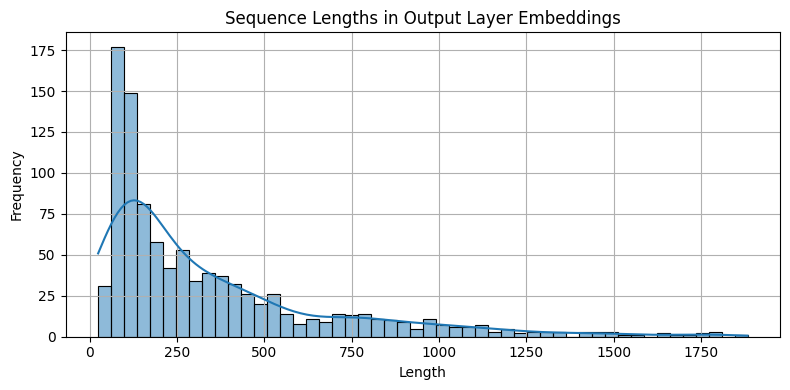

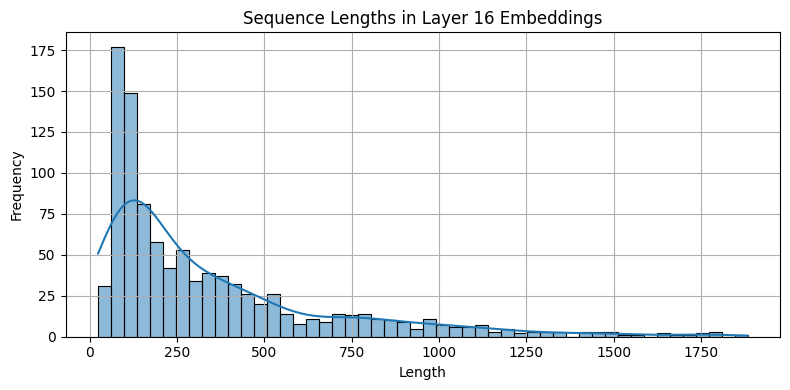

In [13]:

# Plot length distribution
plot_distribution(output_stats["lengths"], "Sequence Lengths in Output Layer Embeddings", "Length")
plot_distribution(layer16_stats["lengths"], "Sequence Lengths in Layer 16 Embeddings", "Length")

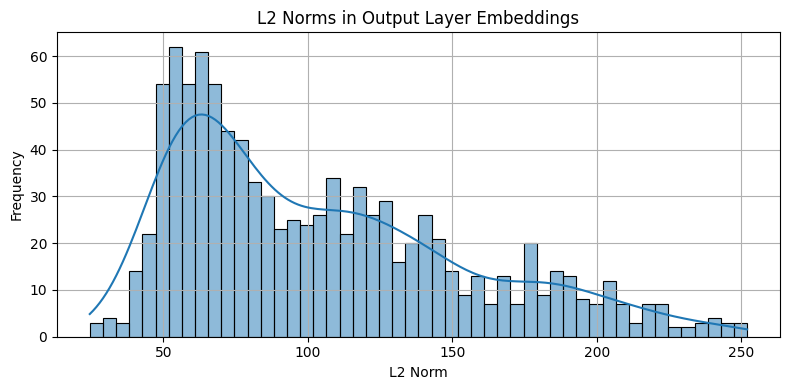

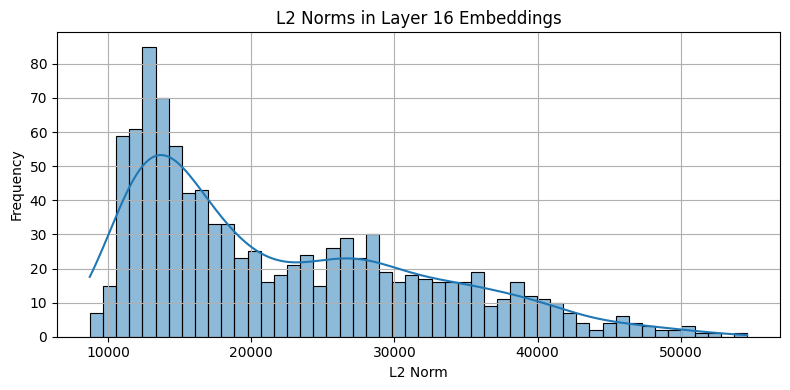

In [14]:
# Plot L2 norm distribution
plot_distribution(output_stats["norms"], "L2 Norms in Output Layer Embeddings", "L2 Norm")
plot_distribution(layer16_stats["norms"], "L2 Norms in Layer 16 Embeddings", "L2 Norm")


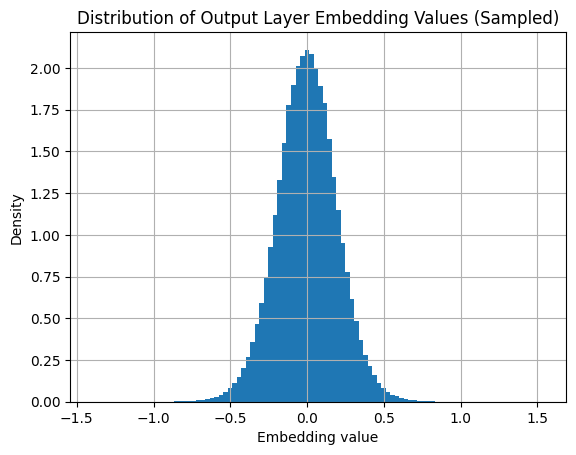

In [16]:
sampled_values = []

with h5py.File(output_embedding_path, "r") as f:
    for i, key in enumerate(f.keys()):
        if i >= 500:
            break
        emb = f[key]
        num_residues = emb.shape[0]

        if num_residues > 10:
            idx = np.random.choice(num_residues, 10, replace=False)
            idx.sort()  # fix: sort the indices to avoid h5py error
            sampled = emb[idx, :]
        else:
            sampled = emb[:]

        sampled_values.append(sampled.flatten())

# Combine all samples into a single array
sampled_values = np.concatenate(sampled_values)

# Plot histogram
plt.hist(sampled_values, bins=100, density=True)
plt.title("Distribution of Output Layer Embedding Values (Sampled)")
plt.xlabel("Embedding value")
plt.ylabel("Density")
plt.grid(True)
plt.show()


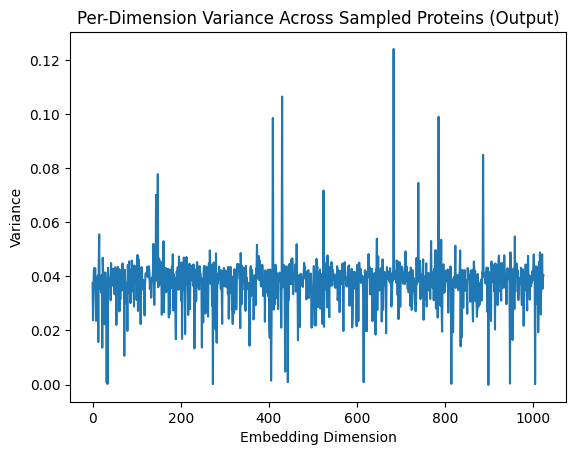

In [25]:
dims = 1024
accum = np.zeros(dims)
squares = np.zeros(dims)
count = 0

with h5py.File(output_embedding_path, "r") as f:
    for key in list(f.keys())[:1000]:
        emb = f[key][:]
        accum += emb.sum(axis=0)
        squares += (emb ** 2).sum(axis=0)
        count += emb.shape[0]

mean = accum / count
var = (squares / count) - (mean ** 2)

plt.plot(var)
plt.title("Per-Dimension Variance Across Sampled Proteins (Output)")
plt.xlabel("Embedding Dimension")
plt.ylabel("Variance")
plt.show()


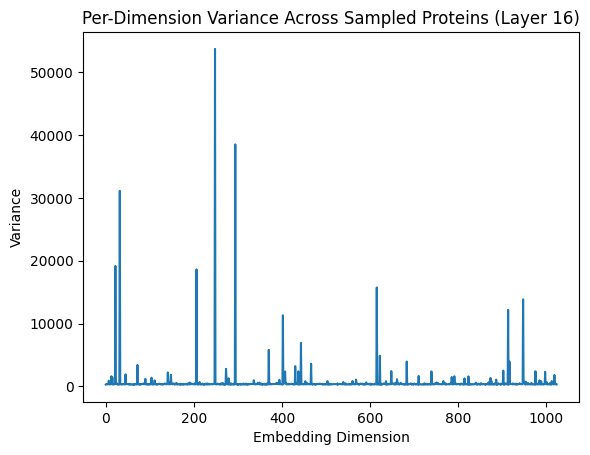

In [26]:
dims = 1024
accum = np.zeros(dims)
squares = np.zeros(dims)
count = 0

with h5py.File(layer16_embedding_path, "r") as f:
    for key in list(f.keys())[:1000]:
        emb = f[key][:]
        accum += emb.sum(axis=0)
        squares += (emb ** 2).sum(axis=0)
        count += emb.shape[0]

mean = accum / count
var = (squares / count) - (mean ** 2)

plt.plot(var)
plt.title("Per-Dimension Variance Across Sampled Proteins (Layer 16)")
plt.xlabel("Embedding Dimension")
plt.ylabel("Variance")
plt.show()


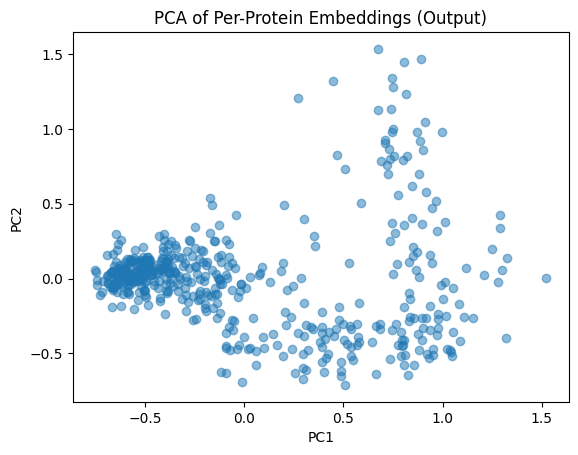

In [28]:
from sklearn.decomposition import PCA

all_embeddings = []
with h5py.File(output_embedding_path, "r") as f:
    for key in list(f.keys())[:500]:  # 500 proteins
        emb = f[key][:]  # shape (L, 1024)
        all_embeddings.append(emb.mean(axis=0))  # per-protein avg vector

all_embeddings = np.vstack(all_embeddings)

pca = PCA(n_components=2)
proj = pca.fit_transform(all_embeddings)

plt.scatter(proj[:, 0], proj[:, 1], alpha=0.5)
plt.title("PCA of Per-Protein Embeddings (Output)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


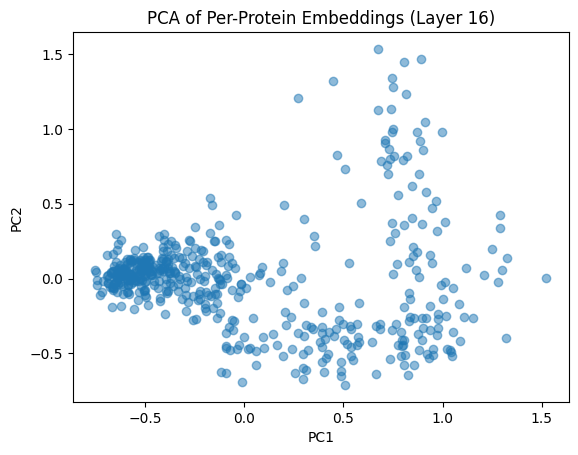

In [29]:
all_embeddings = []
with h5py.File(output_embedding_path, "r") as f:
    for key in list(f.keys())[:500]:  # 500 proteins
        emb = f[key][:]  # shape (L, 1024)
        all_embeddings.append(emb.mean(axis=0))  # per-protein avg vector

all_embeddings = np.vstack(all_embeddings)

pca = PCA(n_components=2)
proj = pca.fit_transform(all_embeddings)

plt.scatter(proj[:, 0], proj[:, 1], alpha=0.5)
plt.title("PCA of Per-Protein Embeddings (Layer 16)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


In [35]:
threshold = 1e-4
low_var_dims = np.where(var < threshold)[0]
print(f" Number of low-variance dims (<{threshold}): {len(low_var_dims)}")
print("Indices:", low_var_dims)


 Number of low-variance dims (<0.0001): 1
Indices: [898]
